# Simple Anomaly Detection in Time Series via Optimal Baseline Subtraction (OBS)
**Anomaly detection** in time series is used to identify unexpected patterns in your time series, and it is widely applied in different fields. In **energy engineering**, a spike in power usage might signal a fault. In **finance**, sudden drops or peaks can indicate major market events. In **mechanical systems**, unusual vibrations may reveal early signs of failure. In this blogpost, we will use **weather data** as an example use case, and we will find the anomalies in temperature time series for different cities all over the world.  

## Optimal Baseline Subtraction (OBS) Description

### OBS Introduction

If you have a bank of time series and you want to understand if and in what portion of the time series you have an anomaly, a simple but very efficient metod is called **optimal baseline subtraction (OBS)**. OBS is based on comparing each time series segment to the most similar historical pattern and analyzing the difference to detect unexpected deviations. 

### OBS Algorithm

The OBS algorithm is the following:

- **Split the time series into individual segments**, where each segment represents a unit of repeated behavior (e.g., a day, a cycle, or a process run).
- **Build a library of historical segments** by collecting all previous segments in the time series bank.
- **Compare your target segment** with all other segments in the library using a similarity metric, such as Mean Absolute Error (MAE).
- **Select the most similar segment** from the library as the optimal baseline.
- **Subtract the baseline from the target segment** to isolate the residual (i.e., the difference).
- **Analyze the residual** to identify large deviations, which are flagged as potential anomalies.

![Alt text](images/Workflow.png)



## Optimal Baseline Subtraction Application

### Script folder

You can find all the code and data you need in this [public github folder](https://github.com/PieroPaialungaAI/OptimalBaselineSubtraction.git), that you can download with:

```bash
git clone https://github.com/PieroPaialungaAI/OptimalBaselineSubtraction.git
```

### Data Source

The data used for this article originally come from an Open Database on Kaggle. You can find the original source of the dataset [here](https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data). Nonetheless, note that **you don't need to download it again, as everything you need is in the ```OBS_Data``` folder.**

### Preprocessed Data

The "preprocessing" part of the data is handled by the ```data.py``` code, so we can just deal with the fun stuff here. 

A table with the attributes for the cities can be found in the ```.city_attribute_data```:




In [1]:
from data import *
data = TimeSeriesData()
data.city_attribute_data.head()

,City,Country,Latitude,Longitude
0,Vancouver,Canada,49.249660,-123.119339
1,Portland,United States,45.523449,-122.676208
2,San Francisco,United States,37.774929,-122.419418
3,Seattle,United States,47.606209,-122.332069
4,Los Angeles,United States,34.052231,-118.243683


While the correspoding time series can be found in the  ```.temperature_data```, where each column represents a city, and the ```.datetime``` is the time step column. For example, the data for the city of **Vancouver** are the following:

In [2]:
data.temperature_data[['Vancouver','datetime']].head()

,Vancouver,datetime
0,284.630000,2012-10-01 13:00:00
1,284.629041,2012-10-01 14:00:00
2,284.626998,2012-10-01 15:00:00
3,284.624955,2012-10-01 16:00:00
4,284.622911,2012-10-01 17:00:00


### Selecting the Target Segment

So let's say we have our dataset and we want to see if there is an anomaly in a specific section. The following code pulls the city of interest and allows you to pick a specific window (e.g. a day, a week or a month) for that specific city. For example, let's pick **day** number **10** for **city = Los Angeles**.

420


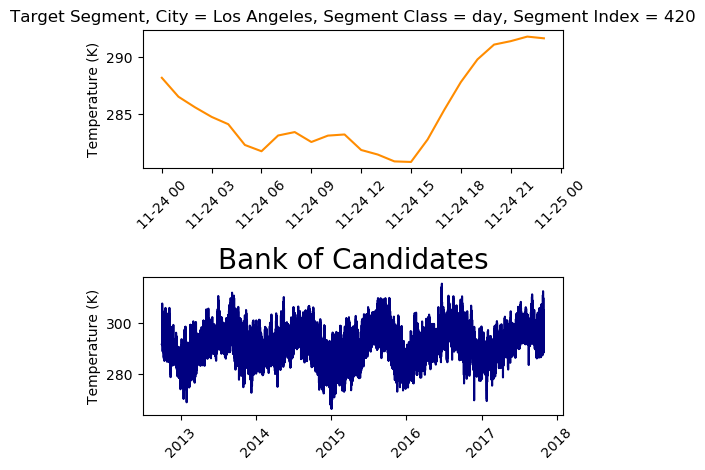

In [3]:
city = 'Los Angeles'
segment_class = 'day'
segment_idx = 420
print(segment_idx)
data.isolate_city_and_time(city = city, segment_idx = segment_idx, segment_class = segment_class)
data.plot_target_and_baseline()

### Selecting the Bank of Candidates

As we selected our city, window and index, all the remaining windows form your bank of candidates. For example, for our **day** window, our segments have 24 points (one per hour). For this reason the list of candidates will have shape ```(number of days - 1, 24)```. 

In [4]:
data.list_of_candidates.shape

(1853, 24)

Let's display some random candidates using the ```plot_target_and_candidates``` via the ```baseline_vs_candidates_plotter```.

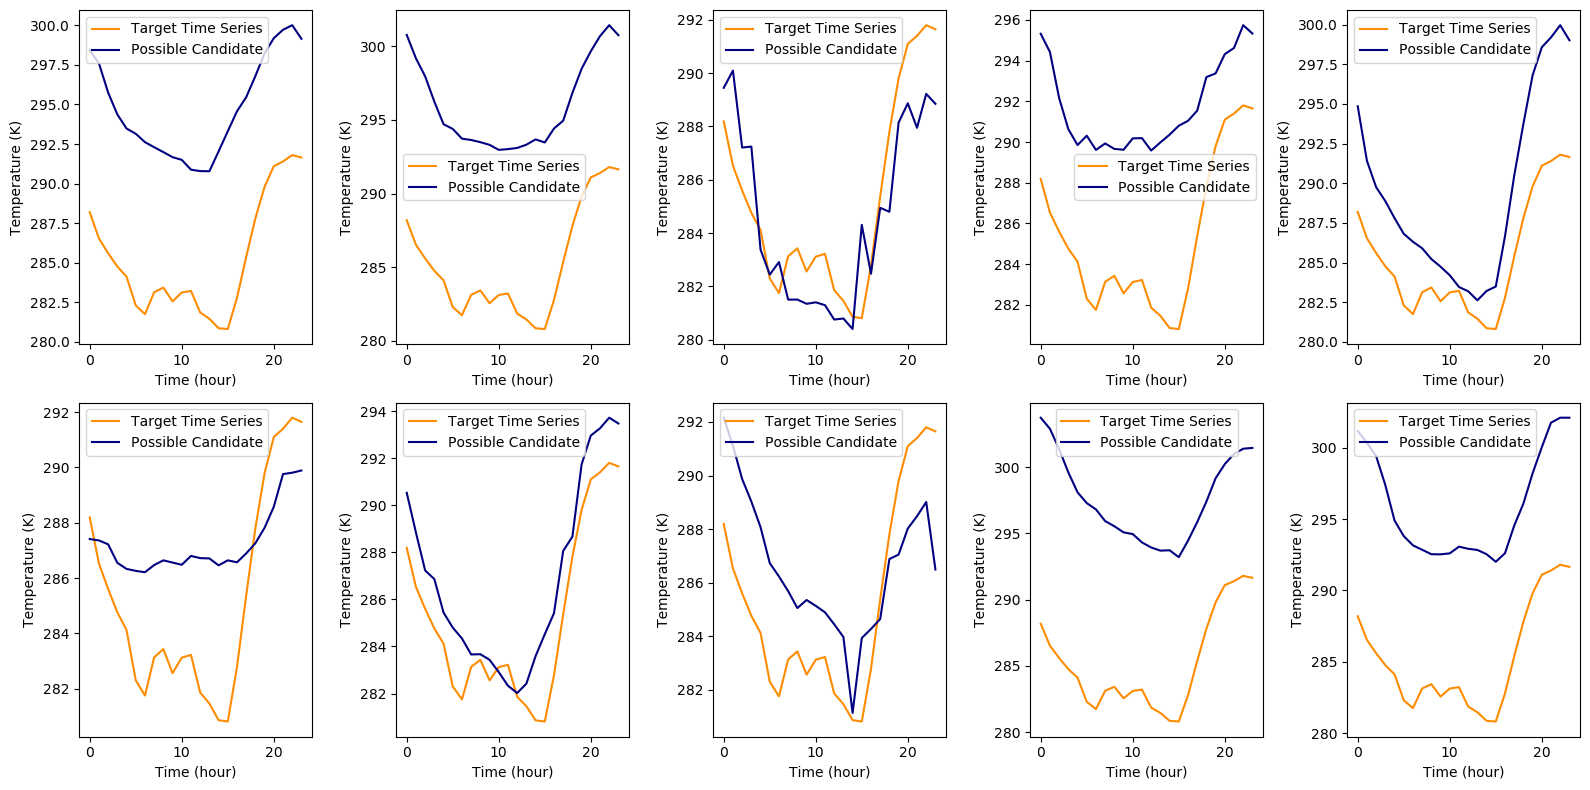

In [5]:
data.plot_target_and_candidates()

### Selecting the optimal baseline  
In this step, we will use the MAE metric to find the time series that is the closest to our target in the list of candidates. 
The result of the Optimal Baseline search has been stored in a dictionary:


In [6]:
optimal_baseline_data = data.find_optimal_baseline()
optimal_baseline_data

{'optimal_baseline_curve': array([287.732     , 287.60066667, 285.32933333, 285.72      ,
        282.56133333, 282.06466667, 282.7135    , 281.835     ,
        282.102     , 282.1435    , 282.48566667, 282.60233333,
        281.1685    , 281.802     , 280.885     , 285.6475    ,
        282.83733333, 285.70666667, 285.995     , 289.72466667,
        290.87333333, 289.9675    , 291.801     , 291.58      ]),
 'optimal_baseline_diff': array([4.58000000e-01, 1.07066667e+00, 2.70666667e-01, 9.60000000e-01,
        1.55866667e+00, 2.35333333e-01, 9.63500000e-01, 1.29500000e+00,
        1.32800000e+00, 4.16500000e-01, 6.34333333e-01, 6.17666667e-01,
        6.91500000e-01, 3.42000000e-01, 2.50000000e-02, 4.83750000e+00,
        5.73333330e-02, 3.36666667e-01, 1.81500000e+00, 7.53333330e-02,
        2.26666667e-01, 1.43250000e+00, 1.00000000e-03, 7.00000000e-02]),
 'optimal_baseline_error': 0.8216180555833409,
 'target_curve': array([288.19, 286.53, 285.6 , 284.76, 284.12, 282.3 , 281.75, 28

Our plot function can be used to display the optimal baseline vs the target curve and the **residual**, which is the absolute difference between the twos divided by the maximum of the target curve (scaling factor):

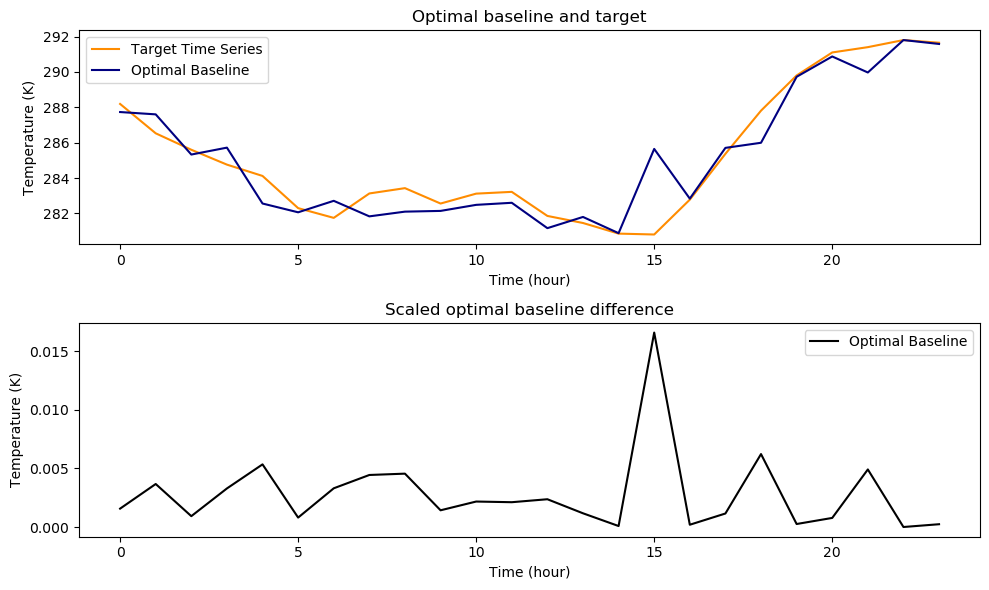

In [7]:
data.plot_target_and_optimal_baseline()

### Anomaly Detection Algorithm
We can see that the target time series is very in line with the Optimal Baseline, except for a small area (around the 15th hour), that we can consider as an **anomaly**. So now we can use a threshold to flag anomalies: any point where the residual exceeds this threshold is considered anomalous, as shown below.

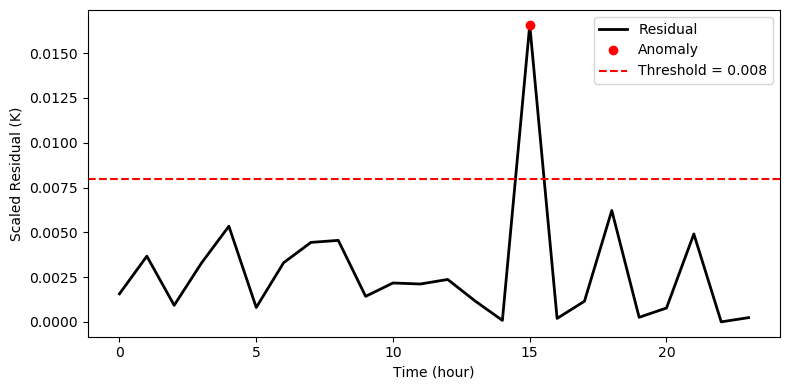

In [8]:
data.run_anomaly_detection(threshold=0.008, plot = True)

## Optimal Baseline Subtraction Considerations
The OBS method is a simple yet powerful approach for detecting anomalies in time series data using historical patterns within a statistical dataset.
Let's list some considerations:
- This method can be considered as a **preprocessing approach** and can be done before applying Machine Learning methods. 
- This method is very versatile, and can be used as an **unsupervised approach**, as shown above. In presence of a labeled dataset (1/0 for anomaly/non anomaly), the choice of the threshold can be calibrated to achieve maximum accuracy
- The performance of this method increases when the historical dataset is **large**, as more optimal baseline (lower error) can be found. 
- The bank of candidates can be personalized, for example by considering only time series that happen **before** the target one, or only time series that belong to a certain class (e.g. only time series from the same city in the example above). 
